# Control Variate and Antithetic Sampling

### Import Libraries

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats import gmean
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

### Define variables

In [2]:
S0 = 100
sigma = 0.2
r = 0.05
q = 0.02
T = 1
m = 4
K = np.arange(90, 125, 5)
D = np.exp(-r*T)
t = np.linspace(T/m, T, m)
#dt = T/m
N = 100 # Monte Carlo sample size
L = 100 # number of trials

# Initialize variables
Call_MC = np.zeros((len(K), L))
Call_CV = np.zeros((len(K), L))
Call_ANT = np.zeros((len(K), L))

### Define Black Formula

In [3]:
def black(F, K, r, T, sigma, q):
    """
    Computes the price of a European call option using the Black-Scholes formula.
    
    Parameters:
    S0 (float): initial stock price
    sigma (float): volatility
    q (float): dividend yield
    r (float): risk-free interest rate
    T (float): time to maturity
    K (float): strike price
    
    Returns:
    float: the estimated price of the call option
    """
        
    d1 = (np.log(F/K) + (-q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    return np.exp(-r*T)*(F*np.exp(-q*T)*Nd1 - K*Nd2)

### Compute new Sigma and Mean using Moments (Geometric)

In [4]:
drift = (r-0.5*sigma**2)*(T/m**2)*sum([i for i in range(1,m+1)])
diffusion = ((T*sigma**2)/(2*m**3))*sum([i**2 for i in range(1,m+1)])
M1_p = np.exp(drift + diffusion)

drift1 = (r-0.5*sigma**2)*((2*T)/m**2)*sum([i for i in range(1,m+1)])
diffusion1 = ((2*T*sigma**2)/(m**3))*sum([i**2 for i in range(1,m+1)])
M2_p = np.exp(drift1 + diffusion1)
M2_p

sigma_p = np.sqrt(np.log(M2_p/M1_p**2)/T)

### Standard MC | Control Variate | Antithetic Variate

In [5]:
for i in range(L):
    # Monte Carlo Asian Call
    W = np.cumsum(np.random.randn(N, m)*np.sqrt(T/m), axis=1)
    S = S0*np.exp((r-q-0.5*sigma**2)*t + sigma*W)
    M = np.mean(S, axis=1)            # Arithmetic mean
    Mv, Kv = np.meshgrid(M, K)
    psi_asian = D*np.maximum(Mv-Kv, 0)  # Arithmetic payoff
    Call_MC[:, i] = np.mean(psi_asian, axis=1)

    # Control variate - Geometric mean
    C = np.exp(np.mean(np.log(S),axis=1))    # Geometric mean
    Sv, _ = np.meshgrid(C, K)
    psi_geo = D*np.maximum(Sv-Kv, 0)   # Geometric payoff
    black_geo = np.tile(black(M1_p*S0, K, r, T, sigma_p, q).reshape(-1,1),(1,100))
    cov_init = np.cov(psi_asian,psi_geo)
    cov = np.array([cov_init[i,i+7] for i in range(7)])
    var = np.array([cov_init[i,i] for i in range(7,14)])
    covar = cov/var
    b_optim = np.tile(covar.reshape(7,1),(1,100))
    psi_cv = psi_asian - b_optim*(psi_geo-black_geo)   
    Call_CV[:, i] = np.mean(psi_cv, axis=1)
    
    # Antithetic Variates
    N1 = 50
    W1 = np.cumsum(np.random.randn(N1, m)*np.sqrt(T/m), axis=1)
    ST = S0*np.exp((r-q-.5*sigma**2)*t + sigma*W1);
    A = np.mean(ST, axis=1)
    Sv,K_v = np.meshgrid(A,K)
    psi_ant = D*(np.maximum(Sv-K_v,0))
    tildeST = S0*np.exp((r-q-0.5*sigma**2)*t - sigma*W1)
    A_tilde = np.mean(tildeST,axis=1)
    tildeSv, _ = np.meshgrid(A_tilde, K)
    tilde_psi = D*(np.maximum(tildeSv - K_v,0))
    Call_ANT[:, i] = np.mean(0.5*(psi_ant + tilde_psi), axis=1)

### Average Values and Standard Error

In [6]:
# compute mean and standard error of trials
avg = np.column_stack((np.mean(Call_MC, axis=1), np.mean(Call_CV, axis=1),np.mean(Call_ANT, axis=1)))
err = np.column_stack((np.std(Call_MC, axis=1), np.std(Call_CV, axis=1),np.std(Call_ANT, axis=1)))

### DataFrame - Average Prices

In [7]:
# create dataframe for standard deviation
avg_df = pd.DataFrame({
    'K': K,
    'Standard MC': avg[:, 0],
    'Control Variate': avg[:, 1],
    'Antithetic Sampling': avg[:, 2]
}).set_index('K')
avg_df

,Standard MC,Control Variate,Antithetic Sampling
K,,,
90,12.228478,11.936119,12.423752
95,8.775159,8.521007,8.900288
100,5.997486,5.781691,6.057615
105,3.890787,3.727510,3.903241
110,2.398103,2.287914,2.379634
115,1.414310,1.341995,1.389213
120,0.799692,0.756077,0.775180


### Plotting Average Prices of Standard MC, Control Variate and Antithetic

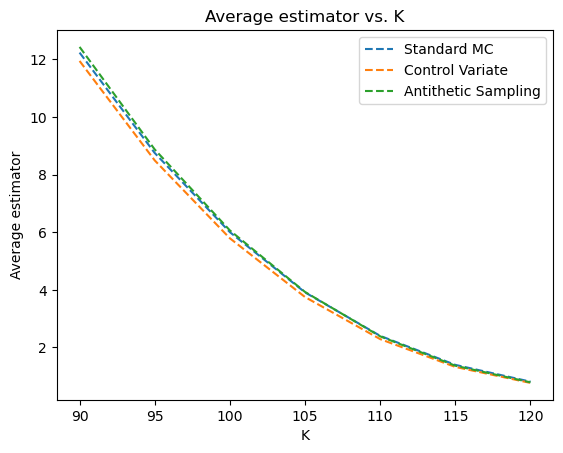

In [8]:
plt.plot(K, savgol_filter(avg[:,0], 7, 3), linestyle='--', label='Standard MC')
plt.plot(K, savgol_filter(avg[:,1], 7, 3), linestyle='--', label='Control Variate')
plt.plot(K, savgol_filter(avg[:,2], 7, 3), linestyle='--', label='Antithetic Sampling')
plt.xlabel('K')
plt.ylabel('Average estimator')
plt.title('Average estimator vs. K')
plt.legend()
plt.show()

### DataFrame - Standard Error

In [9]:
# create dataframe for standard deviation
std_df = pd.DataFrame({
    'K': K,
    'Standard MC': err[:, 0],
    'Control Variate': err[:, 1],
    'Antithetic Sampling': err[:, 2]
}).set_index('K')
std_df

,Standard MC,Control Variate,Antithetic Sampling
K,,,
90,1.105991,0.025905,0.494005
95,1.005180,0.027556,0.594859
100,0.892729,0.024397,0.640913
105,0.751425,0.023437,0.620882
110,0.597650,0.023855,0.539801
115,0.457841,0.026546,0.432710
120,0.345895,0.027367,0.330575


Observation:
1. The control variate sees a significant drop in standard error when compared to Standard Monte Carlo for ITM options
2. The Antithetic sampling standard errors see a drop of more than 50% when compared to Standard Monte Carlo for ITM options
3. For ITM options the variance reduciton works very well, but for OTM options it does not.
4. The geometric asian works very well as a control variate since it is highly correlated with arithmetic asian options
5. We see that control variate method shows the best results in terms of average prices and standard errors